In [1]:
import random

import numpy as np
import tables

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
parents = [['AD0231-C', 'AD0232-C'], ['AD0254-C', 'AD0255-C'],
           ['AD0305-C', 'AD0306-C'], ['AD0347-C', 'AD0348-C']]

crosses_3L_h5 = '../raw/crosses-3L.h5'

In [3]:
def get_offspring_range(parents, all_parents, samples):
    my_index = samples.index(parents[1])
    start = my_index + 1
    parents_position = all_parents.index(parents)
    if  parents_position == len(all_parents) - 1:
        end = len(samples)
    else:
        end = samples.index(all_parents[parents_position + 1][0])
    return start, end

In [4]:
store_3L = tables.open_file(crosses_3L_h5, 'r')

In [5]:
samples = [x.decode('utf-8') for x in store_3L.get_node('/3L/samples').read()]

In [6]:
def compute_medelian_errors(parents, offspring):
    #autosome only
    mo_alleles = set(parents[0])
    fa_alleles = set(parents[1])
    if set([-1]) in [mo_alleles, fa_alleles]:
        return
    if len(mo_alleles) == 2 and len(fa_alleles) == 2:
        #Both HZ, this case it not trivial
        return
    cnt = cnt_mo = cnt_fa = total = 0
    for ofs in offspring:
        my_alleles = set(ofs)
        if set(ofs) == set([-1]):
            continue
        total += 1
        if len(my_alleles & mo_alleles) == 0:
            cnt += 1
            cnt_mo += 1
        if len(my_alleles & fa_alleles) == 0:
            cnt += 1
            cnt_fa += 1
        # Ofspring has more alleles (hz) than parents
        if len(my_alleles) > len(fa_alleles | mo_alleles):
            cnt += 1
    return total, cnt, cnt_mo, cnt_fa
#discuss probs of 01 01 01 01 01 if both parents hz

In [7]:
poses = store_3L.get_node('/3L/variants/POS').read()
num_alleles = store_3L.get_node('/3L/variants/num_alleles').read()
genotypes = store_3L.get_node('/3L/calldata/genotype').read()

In [8]:
my_parents = parents[0]
ofs_mo = samples.index(my_parents[0])
ofs_fa = samples.index(my_parents[1])
ofs_start, ofs_end = get_offspring_range(my_parents, parents, samples)

i = 0
mendel_results = []
for pos, na, genotype in zip(poses, num_alleles, genotypes):
    if random.randint(0, 100) < 90:
        continue
    if na != 2:
        continue
    i += 1
    mo_alleles = genotype[ofs_mo,:]
    fa_alleles = genotype[ofs_fa,:]
    ofs_alleles = genotype[ofs_start:ofs_end,:]
    errors = compute_medelian_errors([mo_alleles, fa_alleles], ofs_alleles)
    mendel_results.append((pos, errors))
    #print(mo_alleles, fa_alleles, ofs_alleles)
    #if i == 100:
    #    break

del genotypes

In [9]:
usable = [pos for pos, errors in mendel_results if errors is not None]
has_errors = [(pos, errors) for pos, errors in mendel_results if errors is not None and errors[1] > 0]
len(mendel_results), len(usable), len(has_errors)
#under estimation

(263658, 237095, 32505)

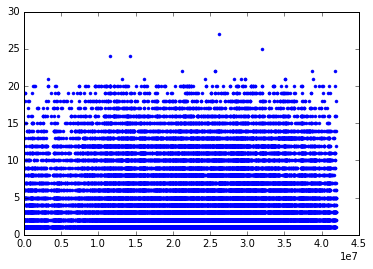

In [10]:
x, y = zip(*((error[0], error[1][1]) for error in has_errors))
plt.plot(x, y, '.')

In [11]:
window_size = 250000
max_pos = usable[-1]
num_bins = max_pos // window_size + 1
wins = [[0, 0] for x in range(num_bins)]
for pos in usable:
    wins[pos // window_size][0] += 1
for pos_err in has_errors:
    pos = pos_err[0]
    wins[pos // window_size][1] += 1
frac_errors = [errs / poses for poses, errs in wins]

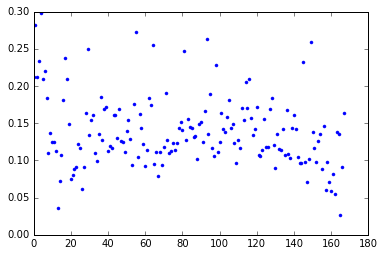

In [12]:
plt.plot(frac_errors, '.')

In [13]:
for entry in store_3L.get_node('/3L/variants'):
    print(entry)

/3L/variants/AC (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/AF (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ALT (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/AN (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ANN (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Accessible (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/BaseCounts (EArray(2501730, 4), shuffle, zlib(1)) ''
/3L/variants/BaseQRankSum (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/CHROM (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/ClippingRankSum (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Coverage (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/CoverageMQ0 (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/DP (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/DS (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/Dels (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/FILTER_LowQual (EArray(2501730,), shuffle, zlib(1)) ''
/3L/variants/FILTER_PASS (EAr

In [14]:
store_3L

File(filename=../raw/crosses-3L.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/3L (Group) ''
/3L/samples (Array(80,)) ''
  atom := StringAtom(itemsize=8, shape=(), dflt=b'')
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := None
/3L/calldata (Group) ''
/3L/calldata/AD (EArray(2501730, 80, 2), shuffle, zlib(1)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (3276, 10, 2)
/3L/calldata/DP (EArray(2501730, 80), shuffle, zlib(1)) ''
  atom := UInt16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (6553, 10)
/3L/calldata/GQ (EArray(2501730, 80), shuffle, zlib(1)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (13107, 10)
/3L/calldata/GT (EArray(2501730, 80), shuffle, zlib(1)